In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import random

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

import pandas as pd
import seaborn as sns
import scipy.stats as st

In [161]:
#To visualize the whole grid
pd.options.display.max_columns = 999
#Kaggle divides the dataset already into Train and Test data
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

def adj_r2_score(y_test, y_pred, X_test):
    num = (1-r2_score(y_test, y_pred)) * (len(X_test)-1)
    den = (len(X_test)-len(X_test.columns)-1)
    return 1 - (num / den)

def normalize(data):
    x = data
    x = (x - x.mean()) / x.std()
    return x
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [162]:
# Remove outliers based on SalePrice and GrLivArea
train_data = train.drop(index=[692, 1183, 1299, 524], axis=0)
# if house has a pool with an area greater than 0 then 1 else zero
# train_data['Pool'] = train_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# Remodeled indicator
# train_data['Remodeled'] = np.where(train_data.YearBuilt != train_data.YearRemodAdd, 1, 0)

train_data['GrLivArea'] = normalize(train_data.GrLivArea)
train_data['GarageArea'] = normalize(train_data.GarageArea)
train_data['TotalBsmtSF'] = normalize(train_data.TotalBsmtSF)
train_data['LowQualFinSF'] = normalize(train_data.LowQualFinSF)
train_data['KitchenAbvGr'] = normalize(train_data.KitchenAbvGr)

# drop columns that are not needed
train_data['OverallCond'] = train_data['OverallCond'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else 2))
train_data['LowQualFinSF'] = train_data['LowQualFinSF'].apply(lambda x: 0 if x == 0 else 1)
train_data['Bath'] = train_data['HalfBath'] + train_data['FullBath']
train_data['Electrical'] = train_data['Electrical'].apply(lambda x: 'Brk' if x == 'SBrkr' else 'Fuse')
train_data['SaleType'] = train_data['SaleType'].apply(lambda x: 'New' if x == 'New' else 'Not_New')
train_data['SaleCondition'] = train_data['SaleCondition'].apply(lambda x: 'Partial' if x == 'Partial' else 'Not_Partial')
train_data.drop(columns=[
    'LotArea',
    'LotFrontage',
    'YearBuilt',
    'MasVnrType',
    'MasVnrArea',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtFinSF1',
    'BsmtFinSF2',
    '1stFlrSF',
    '2ndFlrSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'HalfBath',
    'FullBath',
    'BedroomAbvGr',
    'TotRmsAbvGrd',
    'GarageYrBlt',
    'GarageCars',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'PoolQC',
    'MiscVal',
    'MoSold',
    'YrSold',
    'MSSubClass',
    'MSZoning',
    'Street',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'ExterCond',
    'BsmtCond',
    'Heating',
    'Functional',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'Fence',
    'MiscFeature'
    ], inplace=True)
# Covert categorical variables into usable terms
train_data = pd.get_dummies(data=train_data, dummy_na=False, columns=[
    'Alley',
    'HouseStyle',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'KitchenQual',
    'GarageType',
    'GarageFinish',
    'SaleType',
    'SaleCondition'
    ])

train_labels = train_data.SalePrice
# train_data.drop(['SalePrice'], axis=1, inplace=True)

print(train_data.shape)
print(train_data.isna().any()[lambda x: x])
# LotFrontage - Linear feet of street connected to property - set to 0
# train_data['LotFrontage'].fillna(0, inplace=True)
# MasVnrArea - Masonry veneer area in square feet - set to 0
# train_data['MasVnrArea'].fillna(0, inplace=True)
# GarageYrBlt - Year garage was built - set to average garage year build
#train_data['GarageYrBlt'].fillna(train_data['GarageYrBlt'].mean(), inplace=True)
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2)
train_data.head()

(1456, 66)
Series([], dtype: bool)


,OverallQual,OverallCond,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,KitchenAbvGr,Fireplaces,GarageArea,SalePrice,Bath,Alley_Grvl,Alley_Pave,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_Brk,Electrical_Fuse,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,SaleType_New,SaleType_Not_New,SaleCondition_Not_Partial,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
828,7,1,2001,1434,0.978614,1,-0.145934,-0.211684,1,0.261485,189000,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0
422,6,1,2000,356,1.337702,1,0.192220,-0.211684,1,0.270920,215000,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0
652,4,1,1950,755,-0.717347,1,0.007041,-0.211684,1,-0.828207,108000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0
370,5,1,2006,733,0.029943,1,-0.441818,-0.211684,1,0.492632,162000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1004,5,1,1976,1680,1.526950,1,0.349220,4.320846,0,0.266203,136905,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0


In [163]:
train_data = pd.concat([
    train_data.OverallQual,
    train_data.GrLivArea,
    train_data.GarageArea,
    train_data.YearRemodAdd,
    train_data.OverallCond,
    train_data.TotalBsmtSF,
    train_data.LowQualFinSF,
    train_data.Bath,
    train_data.KitchenAbvGr,
    train_data.Fireplaces,
    train_data.Alley_Grvl,
    train_data.Alley_Pave,
    train_data['HouseStyle_1.5Fin'],
    train_data['HouseStyle_1Story'],
    train_data['HouseStyle_2Story'],
    train_data['HouseStyle_SLvl'],
    train_data['HouseStyle_SFoyer'],
    train_data['HouseStyle_1.5Unf'],
    train_data['HouseStyle_2.5Fin'],
    train_data['HouseStyle_2.5Unf'],
    train_data.ExterQual_TA,
    train_data.ExterQual_Gd,
    train_data.ExterQual_Ex,
    train_data.ExterQual_Fa,
    train_data.Foundation_PConc,
    train_data.Foundation_CBlock,
    train_data.Foundation_BrkTil,
    train_data.Foundation_Slab,
    train_data.Foundation_Stone,
    train_data.Foundation_Wood,
    train_data.BsmtQual_TA,
    train_data.BsmtQual_Gd,
    train_data.BsmtQual_Ex,
    train_data.BsmtQual_Fa,
    train_data.BsmtExposure_No,
    train_data.BsmtExposure_Mn,
    train_data.BsmtExposure_Av,
    train_data.BsmtExposure_Gd,
    train_data.HeatingQC_TA,
    train_data.HeatingQC_Gd,
    train_data.HeatingQC_Ex,
    train_data.HeatingQC_Fa,
    train_data.CentralAir_Y,
    train_data.CentralAir_N,
    train_data.Electrical_Brk,
    train_data.Electrical_Fuse,
    train_data.KitchenQual_TA,
    train_data.KitchenQual_Gd,
    train_data.KitchenQual_Ex,
    train_data.KitchenQual_Fa,
    train_data.GarageType_Attchd,
    train_data.GarageType_Detchd,
    train_data.GarageType_BuiltIn,
    train_data.GarageType_Basment,
    train_data.GarageType_2Types,
    train_data.GarageType_CarPort,
    train_data.GarageFinish_Unf,
    train_data.GarageFinish_Fin,
    train_data.GarageFinish_RFn,
    train_data.SaleType_New,
    train_data.SaleType_Not_New,
    train_data.SaleCondition_Partial,
    train_data.SaleCondition_Not_Partial
    ], axis=1)
test_data = pd.concat([
    test_data.OverallQual,
    test_data.GrLivArea,
    test_data.GarageArea,
    test_data.YearRemodAdd,
    test_data.OverallCond,
    test_data.TotalBsmtSF,
    test_data.LowQualFinSF,
    test_data.Bath,
    test_data.KitchenAbvGr,
    test_data.Fireplaces,
    test_data.Alley_Grvl,
    test_data.Alley_Pave,
    test_data['HouseStyle_1.5Fin'],
    test_data['HouseStyle_1Story'],
    test_data['HouseStyle_2Story'],
    test_data['HouseStyle_SLvl'],
    test_data['HouseStyle_SFoyer'],
    test_data['HouseStyle_1.5Unf'],
    test_data['HouseStyle_2.5Fin'],
    test_data['HouseStyle_2.5Unf'],
    test_data.ExterQual_TA,
    test_data.ExterQual_Gd,
    test_data.ExterQual_Ex,
    test_data.ExterQual_Fa,
    test_data.Foundation_PConc,
    test_data.Foundation_CBlock,
    test_data.Foundation_BrkTil,
    test_data.Foundation_Slab,
    test_data.Foundation_Stone,
    test_data.Foundation_Wood,
    test_data.BsmtQual_TA,
    test_data.BsmtQual_Gd,
    test_data.BsmtQual_Ex,
    test_data.BsmtQual_Fa,
    test_data.BsmtExposure_No,
    test_data.BsmtExposure_Mn,
    test_data.BsmtExposure_Av,
    test_data.BsmtExposure_Gd,
    test_data.HeatingQC_TA,
    test_data.HeatingQC_Gd,
    test_data.HeatingQC_Ex,
    test_data.HeatingQC_Fa,
    test_data.CentralAir_Y,
    test_data.CentralAir_N,
    test_data.Electrical_Brk,
    test_data.Electrical_Fuse,
    test_data.KitchenQual_TA,
    test_data.KitchenQual_Gd,
    test_data.KitchenQual_Ex,
    test_data.KitchenQual_Fa,
    test_data.GarageType_Attchd,
    test_data.GarageType_Detchd,
    test_data.GarageType_BuiltIn,
    test_data.GarageType_Basment,
    test_data.GarageType_2Types,
    test_data.GarageType_CarPort,
    test_data.GarageFinish_Unf,
    test_data.GarageFinish_Fin,
    test_data.GarageFinish_RFn,
    test_data.SaleType_New,
    test_data.SaleType_Not_New,
    test_data.SaleCondition_Partial,
    test_data.SaleCondition_Not_Partial
    ], axis=1)

#corr = train_data.corr(method = 'pearson')
#f, ax = plt.subplots(figsize=(12,9))
#sns.heatmap(corr, square = True, cmap ="YlGnBu")

In [164]:
# Root Square Mean Error 21509.08
lr = LinearRegression()
lr.fit(train_data, np.log(train_labels))
predicted_labels = lr.predict(test_data)
rmse = np.sqrt(mean_squared_error(test_labels, np.exp(predicted_labels)))
r2 = r2_score(test_labels, np.exp(predicted_labels))
print('Root Square Mean Error ' + str(round(rmse, 2)))
print('R-Squared ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(test_labels, np.exp(predicted_labels), test_data), 3)))

Root Square Mean Error 25256.85
R-Squared 0.898
Adj R-Squared 0.87


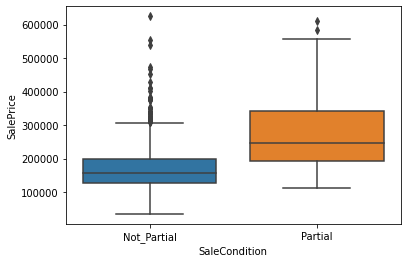

In [128]:
sns.boxplot(x="SaleCondition", y="SalePrice", data=train_data)
plt.show() 

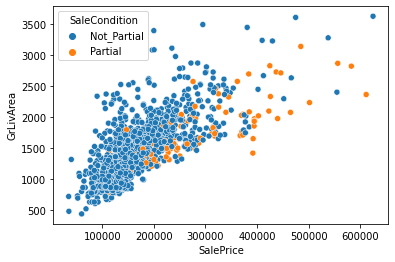

In [129]:
graph_data = pd.concat([train_data['SaleCondition'], train_data.GrLivArea, train_labels], axis=1)
# graph_data['Fence'] = graph_data['Fence'].replace(np.nan, 'None')
# graph_data.head()
# sns.scatterplot('SalePrice', 'GrLivArea', data = graph_data, hue='Remodeled')
sns.scatterplot('SalePrice', 'GrLivArea', data = graph_data, hue='SaleCondition')
plt.show()

Id
433    -0.281080
338     0.061208
1120   -0.931628
76     -1.035715
751    -0.731459
          ...   
483     0.641696
563    -1.019702
306     0.989990
152     0.409501
1418    1.890748
Name: GrLivArea, Length: 1164, dtype: float64
